In [13]:
import os 
import wget
import csv
import dateutil.parser # for parsing plain-text dates
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from collections import defaultdict
from sklearn import linear_model

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_2/data` folder automatically.

In [63]:
filenames = ['fantasy_100.json', 'fantasy_10000.json', 'beer_500.json', 'redditSubmissions.csv']

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)
print("Done!")

Done!


# Regression (lines of best fit)

Read in a small dataset of reviews of fantasy novels (from Goodreads)

In [7]:
path = os.path.join(dataDir, "fantasy_100.json")
f = open(path)

data = []

for l in f:
    d = json.loads(l)
    data.append(d)
    
f.close()

What does the data look like? (json format)

In [8]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '18245960',
 'review_id': 'dfdbb7b0eb5a7e4c26d59a937e2e5feb',
 'rating': 5,
 'review_text': 'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would 

To predict ratings from review length, let's start by assembling vectors of both

In [9]:
ratings = [d['rating'] for d in data]
lengths = [len(d['review_text']) for d in data]

And generating a quick scatter plot of the data to see overall trends...

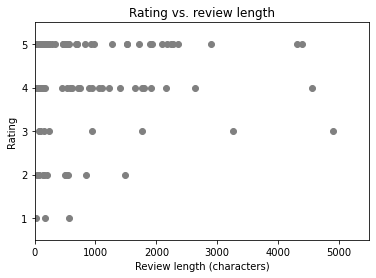

In [10]:
plt.scatter(lengths, ratings, color='grey')
plt.xlim(0, 5500)
plt.ylim(0.5, 5.5)
plt.xlabel("Review length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. review length")
plt.show()

To perform regression, convert to features (X) and labels (y)

In [14]:
X = np.array([[1,l] for l in lengths]) # Note the inclusion of the constant term
y = np.array(ratings).T

Fit a linear regression model to the data (sklearn)

In [15]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

Extract the model coefficients (theta)

In [16]:
theta = model.coef_
theta

array([3.98394783e+00, 1.19363599e-04])

Same thing using numpy (lstsq)...

In [17]:
theta,residuals,rank,s = np.linalg.lstsq(X, y, rcond=None)
theta

array([3.98394783e+00, 1.19363599e-04])

Same thing using by computing the pseudoinverse directly

In [20]:
np.linalg.inv(X.T@X) @ X.T @ y

array([3.98394783e+00, 1.19363599e-04])

Plot the line of best fit...

In [21]:
xplot = np.arange(0,5501,10)
yplot = [(theta[0] + theta[1]*x).item() for x in xplot]

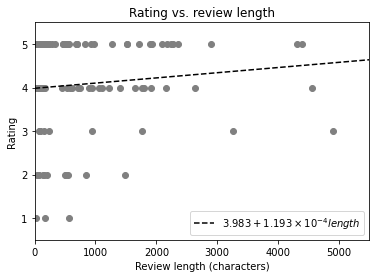

In [22]:
plt.scatter(lengths, ratings, color='grey')
plt.plot(np.array(xplot), yplot, color = 'k', linestyle = '--',\
         label = r"$3.983 + 1.193 \times 10^{-4} \mathit{length}$")
plt.xlim(0, 5500)
plt.ylim(0.5, 5.5)
plt.xlabel("Review length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. review length")
plt.legend(loc='lower right')
plt.show()

Fit a slightly more complex model with two features (review length and number of comments)

In [23]:
def feature(d):
    feat = [1] # Constant feature
    feat.append(len(d['review_text'])) # Length of review
    feat.append(d['n_comments']) # Number of comments
    return feat

In [24]:
X = np.array([feature(d) for d in data])

Fit the model and extract the coefficients

In [25]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([3.95432090e+00, 7.24295694e-05, 1.08071028e-01])

# Mean Squared Error and R^2

Extract model predictions

In [26]:
y_pred = model.predict(X)

Sum of squared errors (SSE)

In [27]:
sse = sum([x**2 for x in (y - y_pred)])

Mean squared error (MSE)

In [28]:
mse = sse / len(y)
mse

1.2298886916501277

### R^2 and fraction of variance unexplained (FVU)

In [29]:
fvu = mse / np.var(y)
r2 = 1 - fvu
r2

0.040573608198668176

Can also get the R^2 coefficient directly from the library...

In [30]:
model.score(X, y)

0.040573608198668176

# Simple feature transformations

Polynomial (quadratic) function

In [31]:
def feature(d):
    feat = [1]
    feat.append(len(d['review_text']))
    feat.append((len(d['review_text']))**2) # Quadratic term
    return feat

In [32]:
X = np.array([feature(d) for d in data])

In [33]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([ 3.86513512e+00,  4.34379750e-04, -8.37700479e-08])

Compute the R^2 coefficient (using the library)

In [35]:
model.score(X, y)

0.026559772903043233

Cubic function

In [36]:
def feature(d):
    feat = [1]
    feat.append(len(d['review_text'])/1000)
    feat.append((len(d['review_text'])/1000)**2) # Quadratic term
    feat.append((len(d['review_text'])/1000)**3) # Cubic term
    return feat

In [37]:
X = np.array([feature(d) for d in data])

In [38]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([ 3.92656525,  0.11531522,  0.14023331, -0.03494859])

In [39]:
model.score(X, y)

0.029260721679258972

## Bar plot of daily ratings trends

Use a (slightly larger) dataset of fantasy reviews

In [43]:
path = os.path.join(dataDir, "fantasy_10000.json")
f = open(path)

data = []

for l in f:
    d = json.loads(l)
    data.append(d)
    
f.close()

Extract averages for each day

In [44]:
weekAverages = defaultdict(list)

for d in data:
    timeString = d['date_added']
    t = dateutil.parser.parse(timeString)
    weekAverages[t.weekday()].append(d['rating'])

for k in weekAverages:
    weekAverages[k] = sum(weekAverages[k]) / len(weekAverages[k])

In [45]:
weekAverages

defaultdict(list,
            {6: 3.755786113328013,
             2: 3.795968234575443,
             5: 3.693290734824281,
             1: 3.7186505410566517,
             0: 3.6558265582655824,
             3: 3.7673956262425445,
             4: 3.7895545314900154})

Plot the averages for each day

In [46]:
xplot = list(weekAverages.keys())
xplot.sort()
yplot = [weekAverages[k] for k in xplot]

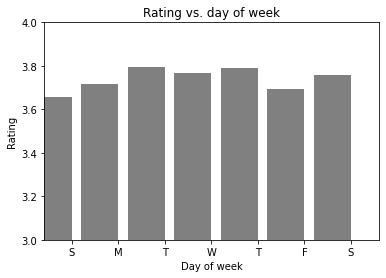

In [47]:
plt.bar(xplot,yplot,color='grey',lw=0)
plt.xticks(np.arange(0.4,7.4,1), ["S", "M", "T", "W", "T", "F", "S"])
plt.xlim(-0.2,7.0)
plt.ylim(3,4)
plt.ylabel("Rating")
plt.xlabel("Day of week")
plt.title(r"Rating vs. day of week")
plt.show()

## Binary (one-hot) features

Read a small dataset of beer reviews with gender attributes

In [53]:
path = os.path.join(dataDir, "beer_500.json")
f = open(path)

data = []

for l in f:
    d = eval(l) 
    data.append(d)
    
f.close()

What does the data look like?

In [54]:
data[0]

{'review/appearance': 2.5,
 'beer/style': 'Hefeweizen',
 'review/palate': 1.5,
 'review/taste': 1.5,
 'beer/name': 'Sausa Weizen',
 'review/timeUnix': 1234817823,
 'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'review/timeStruct': {'isdst': 0,
  'mday': 16,
  'hour': 20,
  'min': 57,
  'sec': 3,
  'mon': 2,
  'year': 2009,
  'yday': 47,
  'wday': 0},
 'review/overall': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'user/profileName': 'stcules',
 'review/aroma': 2.0}

Filter the dataset to include only those users who specified gender

In [55]:
data = [d for d in data if 'user/gender' in d]

How many users have specified gender?

In [56]:
len(data)

215

Binary representation of gender attribute

In [57]:
def feat(d):
    return [1, 1.0 * (d['user/gender'] == 'Female')]

In [58]:
X = [feat(d) for d in data]
y = [len(d['review/text'].split()) for d in data]

Fit a model to the binary feature

In [59]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([127.07177033,   8.761563  ])

The model indicates that females tend to leave slightly longer reviews than males. Plot data from the two groups.

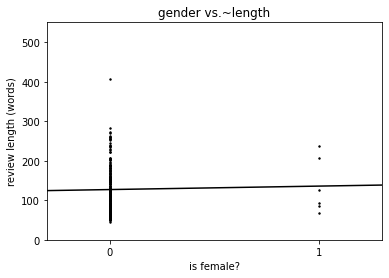

In [60]:
xplot = np.arange(-1,3,1)
yplot = [theta[0] + theta[1]*x for x in xplot]
plt.plot(xplot, yplot, color='k')
plt.scatter([[x[1] for x in X]], y, color='k', s=2)
plt.xlim(-0.3, 1.3)
plt.ylim(0, 550)
plt.xticks([0,1])
plt.xlabel("is female?")
plt.ylabel(r"review length (words)")
plt.title(r"gender vs.~length")
plt.show()

# Transformation of output variables

Dataset of reddit submissions (and resubmissions)

In [65]:
f = open(os.path.join(dataDir, "redditSubmissions.csv"))
cs = csv.reader(f)
header = next(cs)
header

['#image_id',
 'unixtime',
 'rawtime',
 'title',
 'total_votes',
 'reddit_id',
 'number_of_upvotes',
 'subreddit',
 'number_of_downvotes',
 'localtime',
 'score',
 'number_of_comments',
 'username']

Compute popularity as a function of submission number (i.e., how many times has this identical image been submitted)

In [66]:
pops = defaultdict(list)
imId = None
count = 0
for l in cs:
    d = dict(zip(header, l))
    if d['#image_id'] != imId:
        count = 0
    imId = d['#image_id']
    count += 1
    try:
        pops[count].append(int(d['number_of_upvotes']))
    except Exception as e:
        continue

for x in pops:
    pops[x] = sum(pops[x]) / len(pops[x])

Extract a single feature which is just the submission number (0 for first submission, etc., 1 for first resubmission, etc.)

In [67]:
x = list(pops.keys())
x.sort()
X = [[1,a] for a in x]

The label to predict is the number of upvotes as a function of submission number

In [69]:
y = np.array([pops[a] for a in x])
ylog = np.array([math.log2(a) for a in y])

Fit two models: one with the original output variable, one with a log-transformed output variable

In [70]:
mod = linear_model.LinearRegression(fit_intercept = False)
modlog = linear_model.LinearRegression(fit_intercept = False)

mod.fit(X,y)
modlog.fit(X,ylog)

theta = mod.coef_
thetalog = modlog.coef_

Plot data and fitted values for the two models

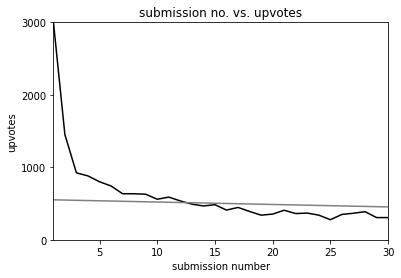

In [71]:
plt.plot(x,y,color='k')
plt.xlim(1,30)
plt.ylim(0,3000)
x1 = [0,30]
y1 = [theta[0] + theta[1]*a for a in x1]
plt.plot(x1,y1,color='grey')
plt.xlabel("submission number")
plt.ylabel("upvotes")
plt.yticks([0,1000,2000,3000])
plt.title("submission no. vs. upvotes")
plt.show()

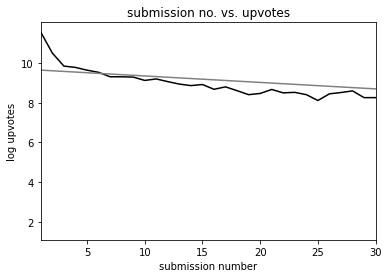

In [72]:
plt.plot(x,ylog, color='k')
plt.xlim(1,30)
x1 = [0,30]
y1 = [thetalog[0] + thetalog[1]*a for a in x1]
plt.plot(x1,y1, color='grey')
plt.xlabel("submission number")
plt.ylabel("log upvotes")
plt.yticks([2,4,6,8,10])
plt.title("submission no. vs. upvotes")
plt.show()

# Exercises

### 2.1

Simple regression question, same form as the examples above

In [73]:
path = os.path.join(dataDir, "fantasy_100.json")
f = open(path)
data = []
for l in f:
    d = json.loads(l)
    data.append(d)
f.close()

In [74]:
ratings = [d['rating'] for d in data]
lengths = [len(d['review_text']) for d in data]

In [75]:
X = np.array([[1,l] for l in lengths]) # Note the inclusion of the constant term
y = np.array(ratings).T

In [76]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

Extract theta

In [77]:
theta = model.coef_
theta

array([3.98394783e+00, 1.19363599e-04])

In [78]:
y_pred = model.predict(X)

In [79]:
sse = sum([r**2 for r in y - y_pred])

MSE

In [80]:
mse = sse / len(y)
mse

1.2657516806241746

### 2.2

Fit a model with an additional variable

In [81]:
def feat(d):
    f = [1]
    f.append(len(d['review_text']))
    f.append(d['n_comments'])
    return f

In [82]:
X = np.array([feat(d) for d in data])

In [83]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

Extract theta

In [84]:
theta = model.coef_
theta

array([3.95432090e+00, 7.24295694e-05, 1.08071028e-01])

Compute the MSE

In [85]:
y_pred = model.predict(X)
sse = sum([r**2 for r in y - y_pred])
mse = sse / len(y)
mse

1.2298886916501277

(explanation: the coefficient of length becomes smaller, as the variability in ratings is already largely explained by the number of comments)

### 2.3

Sketch proof:

$\frac{\partial}{\partial \theta_0} \sum_i (\theta_0 - y_i)^2 = 2\sum_i (\theta - y_i)$

equals zero when $\sum_i \theta = \sum_i y_i$, i.e., $\theta = \frac{1}{N} \sum_i y_i$

### 2.4

Sketch:

$\frac{\partial}{\partial \theta_0} \sum_i | \theta_0 - y_i | = \sum_i \delta(y_i > \theta_0) - \sum_i \delta(y_i < \theta_0)$

zero when $\theta_0$ is the median value of $y$ (meaning that the two terms balance out)

### 2.5

Sketch:

$\max_\theta \prod_i \frac{1}{2b}\exp(-\frac{|x_i\cdot \theta - y_i|}{b})$

$= \max_\theta \sum_i -| x_i \cdot \theta - y_i |$

$= \min_\theta \sum_i | x_i \cdot \theta - y_i|$

### 2.6

Sketch:

rewrite $\sum_i (x_i \cdot \theta - y_i)^2$ as $(X\theta - y)^T(X\theta - y)$

$= (\theta^TX^T - y^T)(X\theta - y)$

$= \theta^TX^TX\theta -2y^TX\theta -y^Ty$ (all terms are scalar)

$\frac{\partial}{\partial \theta} (\theta^TX^TX\theta -2y^TX\theta +y^Ty) = 2(\theta^T X^TX - y^TX)$

$= 0$ when $\theta^TX^TX = y^TX$; or when $X^T X \theta = X^Ty$

i.e., when $\theta = (X^TX)^{-1}X^Ty$

### 2.7

Similar to 2.3: when solving $\theta$ by computing $\frac{\partial}{\partial \theta} \sum_i (x_i \cdot \theta - y_i)^2 = 2\sum_i (x_i \cdot \theta - y_i)$, the expression will be minimized when $\sum_i (x_i \cdot \theta - y_i) = 0$